In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('creditcard.csv')

In [20]:
df2 = df.drop(['Time','Amount'],axis=1)

### Exploring the data

In [21]:
rst = df2.describe()
rst.style

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
mean,3.91956e-15,5.68817e-16,-8.76907e-15,2.78231e-15,-1.55256e-15,2.01066e-15,-1.69425e-15,-1.92703e-16,-3.13702e-15,1.76863e-15,9.17032e-16,-1.81066e-15,1.69344e-15,1.47905e-15,3.48234e-15,1.39201e-15,-7.52849e-16,4.32877e-16,9.04973e-16,5.0855e-16,1.53729e-16,7.95991e-16,5.36759e-16,4.45811e-15,1.453e-15,1.6991e-15,-3.66016e-16,-1.20605e-16,0.00172749
std,1.9587,1.65131,1.51626,1.41587,1.38025,1.33227,1.23709,1.19435,1.09863,1.08885,1.02071,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.62446,0.605647,0.521278,0.482227,0.403632,0.330083,0.0415272
min,-56.4075,-72.7157,-48.3256,-5.68317,-113.743,-26.1605,-43.5572,-73.2167,-13.4341,-24.5883,-4.79747,-18.6837,-5.79188,-19.2143,-4.49894,-14.1299,-25.1628,-9.49875,-7.21353,-54.4977,-34.8304,-10.9331,-44.8077,-2.83663,-10.2954,-2.60455,-22.5657,-15.4301,0
25%,-0.920373,-0.59855,-0.890365,-0.84864,-0.691597,-0.768296,-0.554076,-0.20863,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.49885,-0.456299,-0.211721,-0.228395,-0.54235,-0.161846,-0.354586,-0.317145,-0.326984,-0.0708395,-0.0529598,0
50%,0.0181088,0.0654856,0.179846,-0.0198465,-0.0543358,-0.274187,0.0401031,0.022358,-0.0514287,-0.0929174,-0.0327574,0.140033,-0.0135681,0.0506013,0.0480715,0.0664133,-0.0656758,-0.00363631,0.00373482,-0.0624811,-0.0294502,0.00678194,-0.0111929,0.0409761,0.0165935,-0.0521391,0.00134215,0.0112438,0
75%,1.31564,0.803724,1.0272,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.49315,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.0910451,0.07828,0
max,2.45493,22.0577,9.38256,16.8753,34.8017,73.3016,120.589,20.0072,15.595,23.7451,12.0189,7.84839,7.12688,10.5268,8.87774,17.3151,9.25353,5.04107,5.59197,39.4209,27.2028,10.5031,22.5284,4.58455,7.51959,3.51735,31.6122,33.8478,1


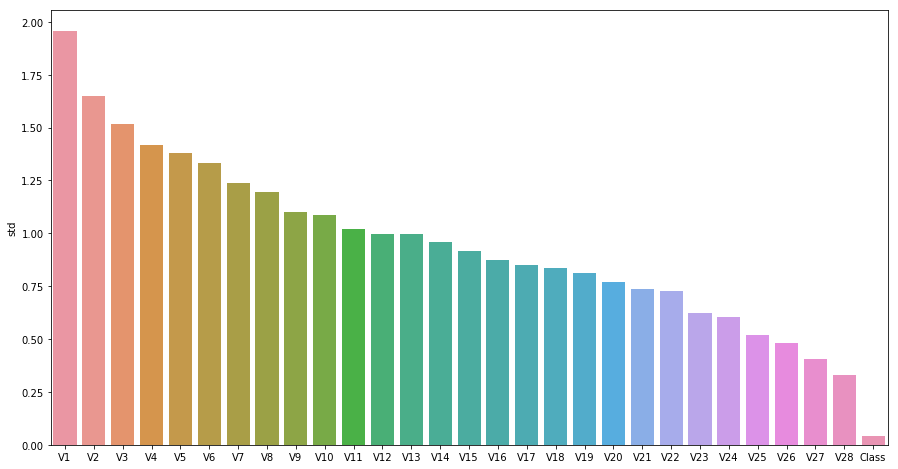

In [22]:
plt.figure(figsize=(15, 8))
sns.barplot(rst.columns,rst.loc['std'])

In [23]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [24]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [25]:
normal_df = df2[df2['Class'] == 0]
fraud_df = df2[df2['Class'] == 1]

down_size = 2*len(fraud_df)
sample_df = pd.concat([normal_df.sample(down_size),fraud_df])

In [96]:
X = sample_df.drop('Class',axis=1)
Y = sample_df['Class']

X_mat = X.as_matrix()
U,S,VT = np.linalg.svd(X_mat.T.dot(X_mat))

In [108]:
np.arange(len(S))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

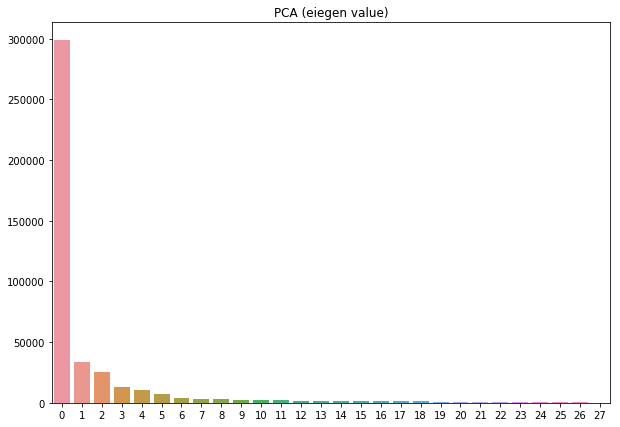

In [110]:
plt.figure(figsize=(10,7))
plt.title('PCA (eiegen value)')
sns.barplot(np.arange(len(S)),S)

In [34]:
RX = X_mat.dot(U[:,:3])

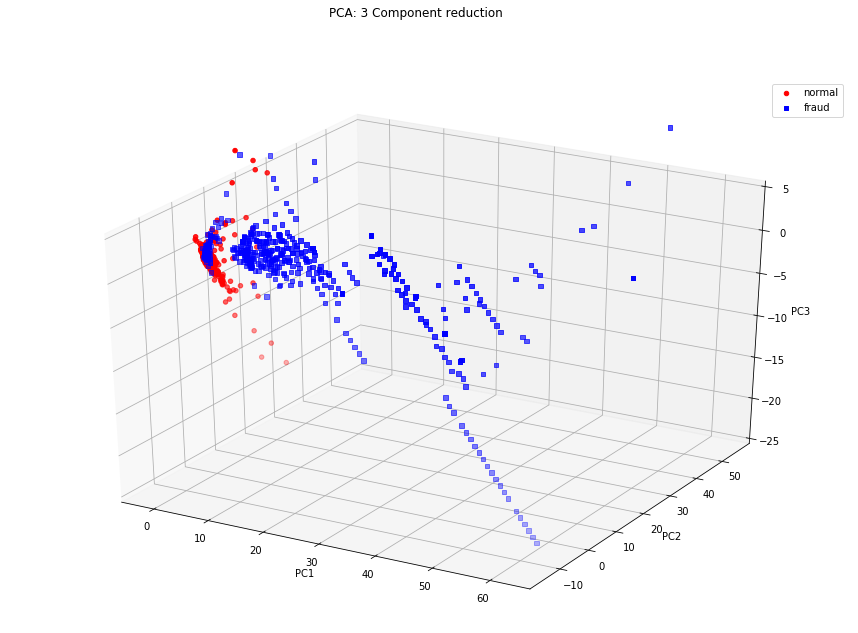

In [35]:
# Create plot
#fig = plt.figure(figsize=(10,6))
#fig = plt.figure(figsize=(10,6))
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,10))
fig.suptitle('PCA: 3 Component reduction')

#ax = axes3d.Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(RX[:down_size,0], RX[:down_size,1], RX[:down_size,2], c='r',label='normal')
ax.scatter3D(RX[down_size:,0], RX[down_size:,1], RX[down_size:,2], c='b',marker='s',label='fraud')


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_zlim(-25,5)
ax.legend()

### Ordered PCA1 component magnitute and Varialbe

In [36]:
pc1 = np.abs(U[:,0])
maxv,minv = pc1.max(),pc1.min()
norm_pc1 = (pc1 - minv)/(maxv-minv) * 100.0


pc2 = np.abs(U[:,1])
maxv,minv = pc2.max(),pc2.min()
norm_pc2 = (pc2 - minv)/(maxv-minv) * 100.0

In [37]:
sample_df.columns[:-1]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

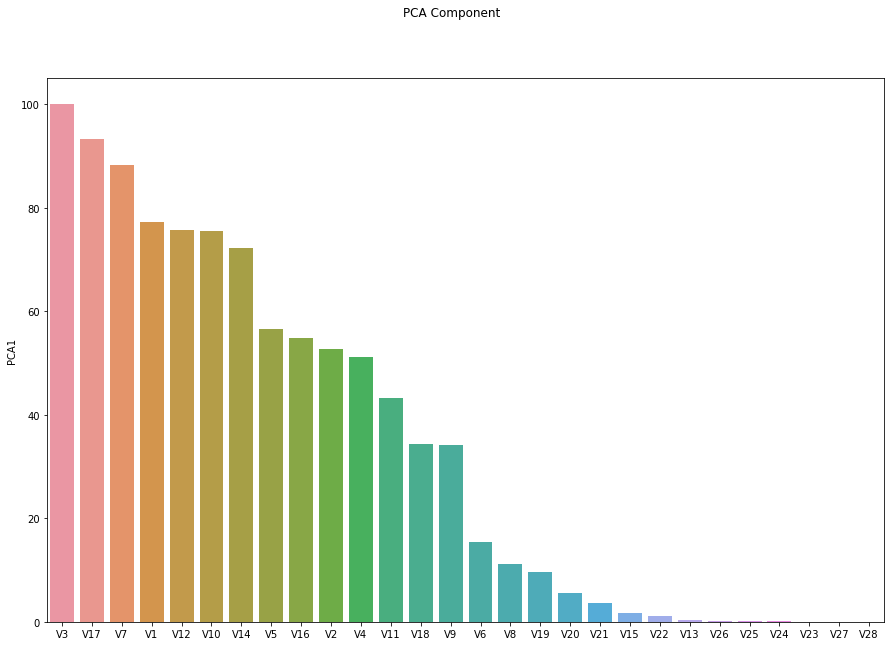

In [38]:
f, ax1 = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
f.suptitle('PCA Component')
ax1.set_ylabel('PCA1')

pairs = zip(sample_df.columns[:-1], norm_pc1)
pairs= sorted(pairs, key=lambda x: x[1], reverse= True)

newx, newy = zip(*pairs)
sns.barplot(newx, newy,ax=ax1)
#ax2.set_ylabel('PCA2')
#sns.barplot(sample_df.columns[:-1], norm_pc2, palette="BuGn_d",ax=ax2)

### Model selection

In [39]:
# V3, V17, V7, V1, ... , V9,  
selected_var = sorted(list(newx[:14]),key=lambda x:int(x[1:]))
SX = X[selected_var]

### Logistic regression

In [40]:
from sklearn import linear_model as skl_lm
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(SX, Y, test_size=0.2, random_state=0)
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train)

rst = clf.predict(X_test)

###  Test set Accuracy (Logistic regression)

In [42]:
acc = np.sum(rst == y_test)/len(y_test)
print('test accuracy : {:.3f}'.format(acc))

test accuracy : 0.966


In [43]:
def aggre_logit(repeat=1):
    
    acc_list = []
    
    for i in range(repeat):
        normal_sample = normal_df.sample(10*len(fraud_df),random_state=i)
        boots_sample = pd.concat([normal_sample,fraud_df])
        X = boots_sample[selected_var]
        Y = boots_sample['Class']
        
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i**2)
        clf = skl_lm.LogisticRegression(solver='newton-cg')
    
        clf.fit(X_train,y_train)
        
        pred = clf.predict(X_test)
        pred_pro = clf.predict_proba(X_test)
        
        pred_th = np.array([1 if i >0.05 else 0 for i in pred_pro[:,1]])
        
        acc = np.sum(pred == y_test)/len(y_test)
        acc_list.append(acc)
        recall = np.sum(pred[y_test == 1]) /np.sum(y_test == 1)
        precs = np.sum(y_test[pred == 1]) /np.sum(pred == 1)
        print('iter = {:>3} - test accuracy : {:.3f} , recall={:.3f} , precs={:.3f}'.format(i,acc,recall,precs))
        print('{:.3f}'.format(np.sum(pred_th[y_test == 1]) /np.sum(y_test == 1)))

        
    print('average accuracy : {:.3f}'.format(np.average(acc_list)))
aggre_logit(30)

iter =   0 - test accuracy : 0.989 , recall=0.862 , precs=1.000
0.908
iter =   1 - test accuracy : 0.985 , recall=0.861 , precs=0.978
0.901
iter =   2 - test accuracy : 0.984 , recall=0.863 , precs=0.953
0.905
iter =   3 - test accuracy : 0.984 , recall=0.832 , precs=1.000
0.891
iter =   4 - test accuracy : 0.989 , recall=0.870 , precs=0.971
0.922
iter =   5 - test accuracy : 0.985 , recall=0.838 , precs=1.000
0.879
iter =   6 - test accuracy : 0.988 , recall=0.875 , precs=0.975
0.909
iter =   7 - test accuracy : 0.982 , recall=0.833 , precs=0.938
0.900
iter =   8 - test accuracy : 0.986 , recall=0.839 , precs=0.986
0.897
iter =   9 - test accuracy : 0.982 , recall=0.838 , precs=0.990
0.872
iter =  10 - test accuracy : 0.981 , recall=0.811 , precs=0.963
0.863
iter =  11 - test accuracy : 0.982 , recall=0.816 , precs=0.976
0.918
iter =  12 - test accuracy : 0.982 , recall=0.836 , precs=0.990
0.888
iter =  13 - test accuracy : 0.985 , recall=0.873 , precs=0.980
0.936
iter =  14 - test ac

### Clustering

In [44]:
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

### K-Means Clustering

### Regression with Regularization (Ridge, Lasso)

In [61]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import ElasticNet

### $$  \frac{\alpha}{N} ||\beta||^2_2 $$

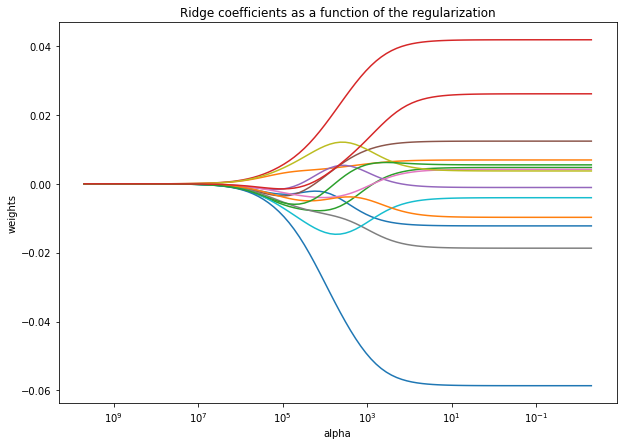

In [74]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
    
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');


$$ \alpha = 0.1 $$

In [93]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred = ridge.predict(X_test)
one_encoding = np.array([ 1 if i > 0.5  else 0 for i in  pred   ] )
acc = np.sum(one_encoding == y_test )/len(y_test)

print('RIDGE Accuracy = {:.3f}'.format(acc))

RIDGE Accuracy = 0.909


### $$ \lambda |\beta|_1 $$

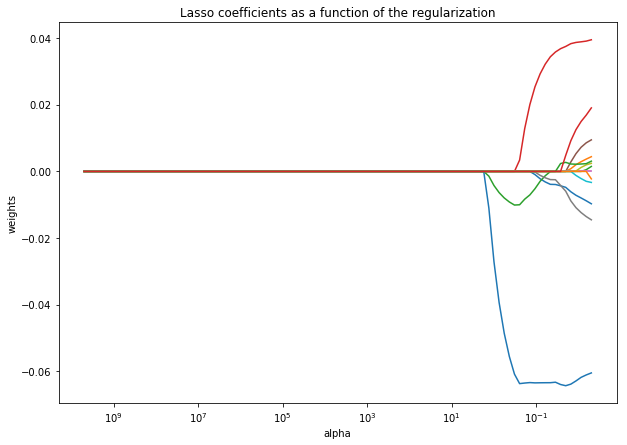

In [85]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [94]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

pred = lasso.predict(X_test)
one_encoding = np.array([ 1 if i > 0.5  else 0 for i in  pred   ] )
acc = np.sum(one_encoding == y_test )/len(y_test)

print('LASSO Accuracy = {:.3f}'.format(acc))

LASSO Accuracy = 0.909


$$ \alpha * \text{L1_ratio} * | W |  + 0.5 * \alpha * (1 - \text{L1_ratio}) * \Vert w \Vert^2 $$

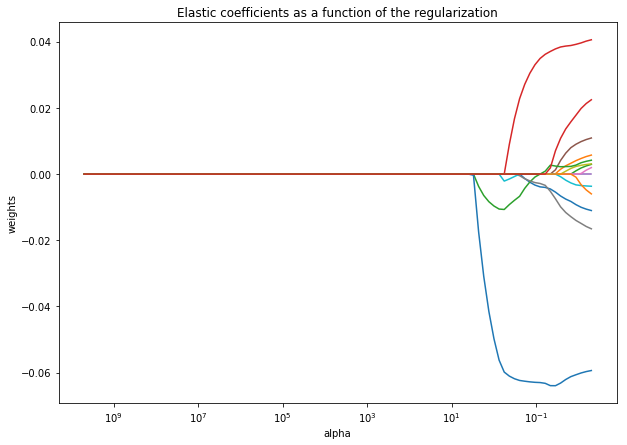

In [89]:
elastic = ElasticNet(random_state=0)
coefs = []

for a in alphas:
    
    elastic.set_params(alpha=a)
    elastic.fit(X_train, y_train)
    coefs.append(elastic.coef_)

f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic coefficients as a function of the regularization');

In [95]:
elastic = ElasticNet(alpha=0.0001,random_state=0)
elastic.fit(X_train, y_train)

pred = lasso.predict(X_test)
one_encoding = np.array([ 1 if i > 0.5  else 0 for i in  pred   ] )
acc = np.sum(one_encoding == y_test )/len(y_test)

print('ELASTIC Accuracy = {:.3f}'.format(acc))

ELASTIC Accuracy = 0.909


### Tree based Model

In [147]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report


### Decision Tree

we had 14 features in train set

In [149]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=14)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=14, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [141]:
clf.score(X_train,y_train)

0.9542372881355933

In [142]:
from sklearn import tree
tree.export_graphviz(clf,out_file='tree.dot')   

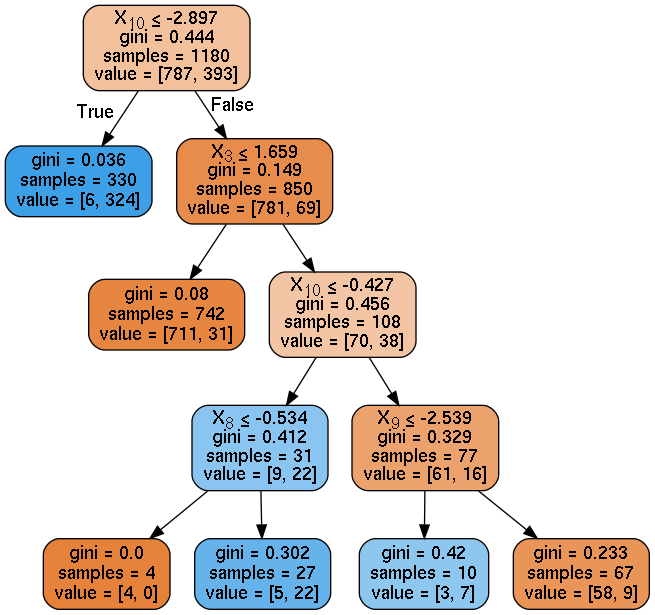

In [143]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [150]:
pred = clf.predict(X_test)
acc = np.sum(pred == y_test )/len(y_test)
print('Decision Tree : {:.3f}'.format(acc))

Decision Tree : 0.956


### Bagging

In [153]:
clf= RandomForestRegressor(max_features=14, random_state=1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=14, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [154]:
clf.score(X_train,y_train)

0.9608944327510338

In [155]:
pred = clf.predict(X_test)
acc = np.sum(pred == y_test )/len(y_test)
error= mean_squared_error(y_test, pred)
print('Baggin Tree : {:.3f}'.format(1-error))

Baggin Tree : 0.958


###  Random Forest

In [158]:
# Random forests: using 6 features

clf = RandomForestRegressor(max_features=14, random_state=1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=14, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [159]:
pred = clf.predict(X_test)
acc = np.sum(pred == y_test )/len(y_test)
error= mean_squared_error(y_test, pred)
print('RandomForest Tree : {:.3f}'.format(1-error))

RandomForest Tree : 0.958


### Boosting

In [160]:
clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
error= mean_squared_error(y_test, pred)
print('RandomForest Tree : {:.3f}'.format(1-error))

RandomForest Tree : 0.969
